In [1]:
import torch
import torch.nn as nn
import numpy as np
from GPT2 import GPT2Model, GPT2Tokenizer

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' #'cuda'

tokenizer = GPT2Tokenizer(
    'GPT2/bpe/vocab.json',
    'GPT2/bpe/chinese_vocab.model',
    max_len=512)

In [2]:
class GPT2classification(nn.Module):
    def __init__(self):
        super(GPT2classification, self).__init__()
        
        self.GPT2model = GPT2Model(
                            vocab_size=30000,
                            layer_size=12,
                            block_size=1024,
                            embedding_dropout=0.0,
                            embedding_size=768,
                            num_attention_heads=12,
                            attention_dropout=0.0,
                            residual_dropout=0.0)

        self.mlp =  nn.Sequential(
                nn.Linear(30000, 512),  # 256, 512
                nn.ReLU(),
                nn.Linear(512, 256),  # 512, 256
                nn.ReLU(),
                nn.Linear(256, 2),  # 256, 2
            )


    def forward(self, x, length):
        x = self.GPT2model(x)
        classify = []
        for i in range(len(length)):
            classify.append(x[i, length[i]].view(-1))
        classify = torch.stack(classify)
        x = self.mlp(classify)
        return x

In [3]:
import json
from data.samplers import RandomSampler
from torch.utils.data import TensorDataset
from tqdm import tqdm

def load_tnews_data(data_path, data_type, tokenizer, few_shot=False, seq_length=1024):

    filename = os.path.join(data_path, data_type+'.json')
    objs = []
    with open(filename) as fin:
        for line in fin:
            objs.append(json.loads(line.strip()))

    pad_id = tokenizer.encoder['<pad>']

    all_tokens = []
    all_last_idx = []
    all_labels = []
    
    for _, obj in enumerate(tqdm(objs)):
        sentence = obj['sentence']
        tokenized_sentence = tokenizer.encode(sentence)[:seq_length-20]
        if obj['label_desc'] == 'news_finance':
            label = 1
        else:
            label = 0

        all_labels.append(label)

        tokens = tokenized_sentence
        token_length = len(tokens)
        tokens.extend([pad_id] * (seq_length - token_length))

        all_last_idx.append(token_length)
        all_tokens.append(tokens)
    
    all_tokens = torch.tensor(all_tokens, dtype=torch.long)
    all_last_idx = torch.tensor(all_last_idx, dtype=torch.long)
    all_labels = torch.tensor(all_labels, dtype=torch.long)
    
    dataset = TensorDataset(all_tokens, all_last_idx, all_labels)

    return dataset
  
def collect_fcn(batch):
    bs = len(batch)
    batch_tokens = []
    batch_idx = []
    batch_labels = []
    for i in range(bs):
        batch_tokens.append(batch[i][0])
        batch_idx.append(batch[i][1])
        batch_labels.append(batch[i][2])
    batch_tokens = torch.stack(batch_tokens)
    batch_idx = torch.stack(batch_idx)
    batch_labels = torch.stack(batch_labels)

    return batch_tokens, batch_idx, batch_labels

In [ ]:
model = GPT2classification()
state_dict = torch.load("./data/financial_finetune_4.pth", map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

In [5]:
torch.save(model, "./data/financial_finetune_full.pth")

In [ ]:
model = torch.load("./data/financial_finetune_full.pth")
model.to(device)

In [6]:
test_set = load_tnews_data('../nlpdata/THUCNews_processed', 'test_financial', tokenizer)
sampler = RandomSampler(test_set)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                                batch_size = 1,
                                                sampler=sampler,
                                                num_workers=0,
                                                collate_fn = collect_fcn,
                                                pin_memory=True)

  0%|          | 0/38300 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.611 seconds.
Prefix dict has been built successfully.
100%|██████████| 38300/38300 [03:36<00:00, 177.07it/s]


In [9]:
import matplotlib.pyplot as plt

num_financial = 0
num_others = 0
num_financial_true = 0
num_others_true = 0
financial_list = []
others_list = []

for i, batch in enumerate(tqdm(test_dataloader)):
    token, last_idx, label = (x.to(device) for x in batch)
    output = model(token, last_idx)
    if label[0] == 1:
        if output[0, 0] < output[0, 1]:
            num_financial_true = num_financial_true + 1
        num_financial = num_financial + 1
        financial_list.append(output.detach().cpu().numpy())
    else:
        if output[0, 0] > output[0, 1]:
            num_others_true = num_others_true + 1
        num_others = num_others + 1
        others_list.append(output.detach().cpu().numpy())
    if i >= 10000:
        break

financial_list = np.array(financial_list).reshape(-1,2)
others_list = np.array(others_list).reshape(-1,2)

 26%|██▌       | 10000/38300 [03:58<11:15, 41.91it/s]


In [10]:
print(num_financial_true/num_financial)
print(num_others_true/num_others)

0.9870826709062003
0.9885288790501107


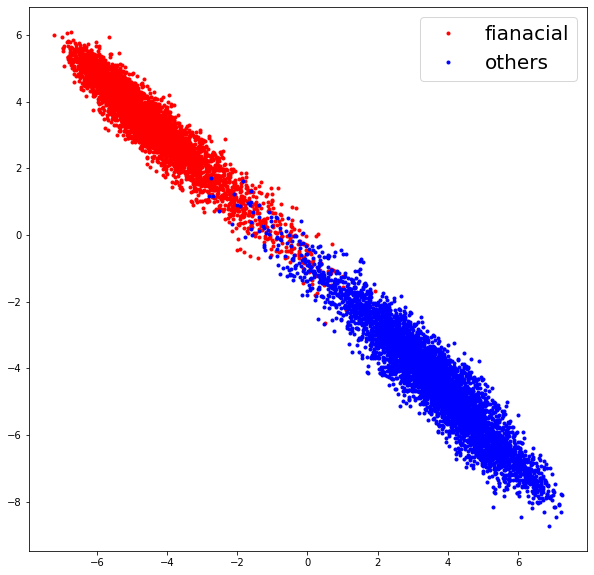

In [11]:
plt.figure(figsize=(10,10))
plt.plot(financial_list[:, 0], financial_list[:, 1], '.', c='r', label='fianacial')
plt.plot(others_list[:, 0], others_list[:, 1], '.', c='b', label='others')
plt.legend(prop={'size': 20})
plt.show()